# Stochastic modelling of COVID19 dataset
## Initial setup

In [341]:
library(tidyr)
library(tidyverse)
library(deSolve)
library(bbmle)
options(repr.plot.width = 8, repr.plot.height =4.5)
dev.new(width=8, height=2.5)


## Base Model: SIR
Now to warm up, we want to use the standard SIR model with no population dynamics:

$\frac{dS}{dt} = -\frac{\beta{S}{I}}{N}$

$\frac{dI}{dt} = \frac{\beta{S}{I}}{N} - \gamma{I}$

$\frac{dS}{dt} = \gamma{I}$

Creating this model in R:

In [342]:
SIR <- function(time, variables, parameters) {
  with(as.list(c(variables, parameters)), {
    dS <- -beta * I * S
    dI <- beta * I * S - gamma * I
    dR <-  gamma * I
    return(list(c(dS, dI, dR)))
  })
}

We then create a function to return an approximate value for our model given all parameters, and return the infectious curve:

In [343]:
model <- function (gamma, beta, times, initial_data) {
    out <- ode(func=SIR, y=initial_data,
               times=times,parms=c(gamma=gamma,beta=beta))
    out[-1,3]
}

## Dataset: Flu in Boarding School
We have the classic dataset from a flu outbreak in a boarding school. Obtained from https://rdrr.io/cran/outbreaks/man/influenza_england_1978_school.html

In [344]:
df <- data.frame(read.csv('BoardingSchoolFlu.csv', header=TRUE))
N = 763
S0 = N - df$days[1]
I0 = df$days[1]
R0 = 0

And the graphing our cases over time:

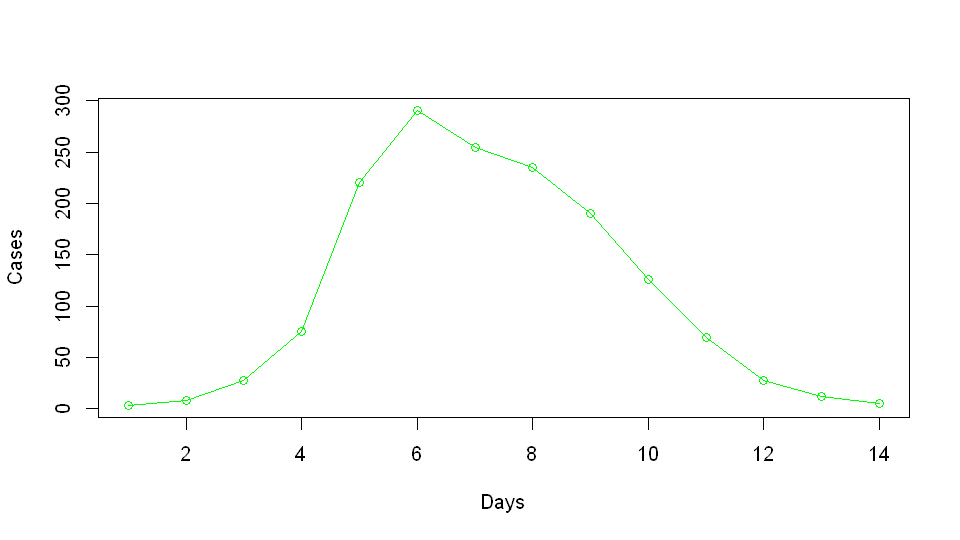

In [345]:
plot(df$days, df$cases, xlab='Days', ylab='Cases', col='green')
lines(df$days, df$cases,col='green')

## Parameter Estimation: MLE's using Normal Distribution 
We now want to create a maximum likelihood estimator of our model, with the aim of numerically maximising this to find estimates for our model's parameters.
We first assume each observation is normally distributed, with constant variance $\sigma^2$:

$Y_t \sim N(I_t, \sigma^2)$.
We want a function that will give a log likelihood of our dataset. To do this generally, assume that each datapoint has the same distribution with parameters $\underline{\theta}$, so each datapoint has the PDF: $f(y |  \underline{\theta})$.
Then our likelihood function is: 
$L =\displaystyle \prod_{t=0}^{n-1}f(Y_t | \underline{\theta}_t)$,
and our log likelihood function is:
$L =\displaystyle \sum_{t=0}^{n-1}\log{(f(Y_t | \underline{\theta}_t))}$ 

At first this is a normal distribution so the likelihood function can be implemented. We return the minus log likelihood as this is what our package uses to estimate parameters.




In [346]:
likelihood <- function(gamma, beta,sigma){
    beta <- exp(beta)
    gamma <- exp(gamma)
    sigma <- exp(sigma)
    model_data <- model(beta = beta, gamma = gamma, times=df$days, initial_data=c(S=S0, I=I0, R=R0))
    model_data<-model_data[-1]
    -sum(dnorm(x=df$cases[-1],mean=model_data, sd=sigma, log=TRUE))
}

Our aim is then to maximimise our log-likelihood function, which we can do using the `bblme` package.

In [347]:
initial_params <- c(gamma=0.5, beta=0.005, sigma=1)
results <- mle2(minuslogl = likelihood, start = lapply(initial_params, log),method = "Nelder-Mead")
parameters <- exp(coef(results))
parameters

gamma        beta       sigma 
 0.44477596  0.00217895 16.59921536

Plotting this estimate against our data:

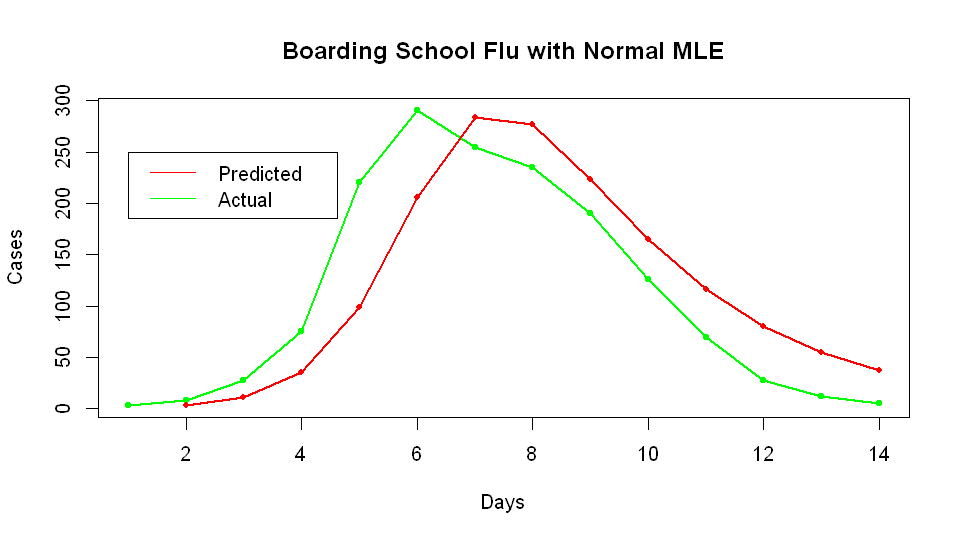

In [348]:
best_model <- model(gamma=as.double(parameters['gamma']), beta=as.double(parameters['beta']), times=df$days, initial_data=c(S=S0, I=I0, R=R0))
best_df <- data.frame(unlist(best_model), unlist(df$days[-1]))
names(best_df)<-c('cases','days')
plot(df$days, df$cases, xlab='Days', ylab='Cases', col='green', lwd=2, pch=20)
legend(1, 250, legend=c("Predicted", "Actual"),
       col=c("red", "green"), lty=1:1, y.intersp=2)
lines(loess(df$cases ~ df$days),col='green', lwd=2)

lines(loess(best_df$cases~best_df$days), col='red', lwd=2)
points(best_df$days, best_df$cases, col='red', pch=20)
title('Boarding School Flu with Normal MLE')

Not a great fit, we can try a poisson distribution instead: $Y_t \sim Po(I_t)$. Our likelihood function is then:

In [349]:
likelihood_po <- function(gamma, beta){
    beta <- exp(beta)
    gamma <- exp(gamma)
    model_data <- model(beta = beta, gamma = gamma, times=df$days, initial_data=c(S=S0, I=I0, R=R0))
    model_data<-model_data[-1]
    -sum(dpois(x = df$cases, lambda = model_data, log = TRUE))
}

We can then repeat our estimation using the library: 

In [350]:
po_initial_params <- c(gamma=0.5, beta=0.005)
po_results <- mle2(minuslogl = likelihood_po, start = lapply(po_initial_params, log),method = "Nelder-Mead")
po_parameters <- exp(coef(po_results))
po_parameters

gamma       beta 
0.44282207 0.00188778

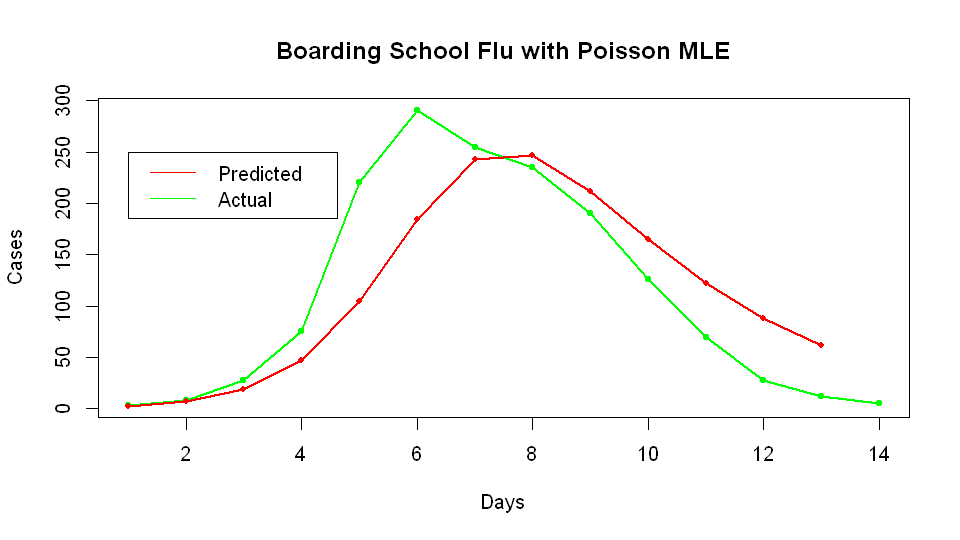

In [351]:
po_model <- model(gamma=as.double(po_parameters['gamma']), beta=as.double(po_parameters['beta']), times=df$days, initial_data=c(S=S0, I=I0, R=R0))
po_df <- data.frame(unlist(po_model), unlist(head(df$days,-1)))
names(po_df)<-c('cases','days')
plot(df$days, df$cases, xlab='Days', ylab='Cases', col='green', lwd=2, pch=20)
legend(1, 250, legend=c("Predicted", "Actual"),
       col=c("red", "green"), lty=1:1, y.intersp=2)
lines(loess(df$cases ~ df$days),col='green', lwd=2)

lines(loess(po_df$cases~po_df$days), col='red', lwd=2)
points(po_df$days, po_df$cases, col='red', pch=20)
title('Boarding School Flu with Poisson MLE')